# Inferring Product Lifecycles and Seasonality 

### What can we infer about the high-level Seasonality of an eCommerce retailer given a year of transaction-level data?
### What 

In [893]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
##https://www.kaggle.com/vijayuv/onlineretail?select=OnlineRetail.csv

In [892]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [896]:
plotly.plotly.

<module 'plotly' from '/opt/anaconda3/lib/python3.8/site-packages/plotly/__init__.py'>

In [631]:
pd.set_option('display.max_columns', 50)

In [634]:
#importing the dataset as a df=ttl
ttl = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/OnlineRetail.csv',encoding= 'unicode_escape')
ttl.columns
ttl.head()
#just to get a sense of the countries for the dataset's transactions
ttl.Country.value_counts()
#Below is jst the counts and totals--91% of the transactions are from the UK
# len(ttl) = 541,909 observations or transactions
# Uk = 495,478 (91%)
# EU ~98%

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [538]:
#getting the unique values of the timestamps of transactions
np.unique(ttl['InvoiceDate'])

array(['1/10/2011 10:04', '1/10/2011 10:07', '1/10/2011 10:08', ...,
       '9/9/2011 9:13', '9/9/2011 9:38', '9/9/2011 9:52'], dtype=object)

In [539]:
#Splitting timestamps from the data in the dataframe--converted and then dropped the orignal 
#expanding to keep all of the info from the timestamp
date = ttl.InvoiceDate.str.split(" ",expand=True)
full = pd.merge(ttl, date, left_index=True, right_index=True)
full.drop(columns=['InvoiceDate',1],inplace=True)
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,12/1/2010
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,12/1/2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,12/1/2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,12/1/2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,12/1/2010


In [638]:
#using the dataset's Unit Price and Quantity to get the sales amount by product
full['Sales_(GBP)']=full['Quantity']*full['UnitPrice']
#Creating a return flag--if a quantity is less than 0, then i classify the boolean of ret (return) as TRUE
#--else FALSE (so a sale)
full['ret'] = full['Quantity'] < 0
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010


In [541]:
#converting to datetime, then converting datetime to new columns with month, day, and year separate
full[0]=pd.to_datetime(full[0])
full['Month']=full[0].dt.month
full['day']=full[0].dt.day
full['year']=full[0].dt.year
full.columns
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010


In [542]:
#I imported a day csv that I created in google sheets to quickly convert
#then dropped those columns into my working dataframe
#Retail companies tend to have a lot of time & date information, so I made sure to have all of that here
##Month is Calendar month--Typical month that anyone is used to seeing
#Day -- same with day
#Year--Same with year
#Wk is using the National Retail Federation's (NRF) 454 Calendar Week--acutally in this case it would be 445, since I am starting the year in January
#454 is a way of structuring the weeks and months so that weeks have the same number of weekdays between years so that they are comparable--always Sun-Sat in a week
#woy is Week of Year--starting with 1 in Jan, 4 weeks in Jan, another 4 in Feb, 5 in Mar, and then quarterly pattern follows the same 445 pattern 
dates = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/days.csv')
dates['date']=pd.to_datetime(dates['date'])
dates.rename(columns={'Unnamed: 2':'woy'},inplace=True)

In [543]:
new = pd.merge(full,dates,left_on=0,right_on='date')
new.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48


In [544]:
#I included 454 Month as a Column, as it sometimes differs from Calendar month
new['454_Month'] = new['Wk'].astype(str).str[0:3]
new.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy,454_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC


In [639]:
##Now I am starting to work with the transation data, and aggregating sales by the dates that I dropped into the DF above
#First grouping by the StockCode/SKU and product description--this is unique by product

#First line is the minimum Week of Year that the product is sold--so a jury rigged 'launch week' essentially
new.groupby(['StockCode','Description'])[['woy']].agg('min')

#Grouping by product by week, making a weekly total DF
new.groupby(['StockCode','Description', 'Wk']).agg('sum')
week_ttl = new.groupby(['Wk'])[['Quantity','Sales_(GBP)']].agg('sum')

#creating a monthly total sales, dropping product info for the monthly totals. I am using monthly totals for reference
cal_month_ttl = new.groupby(['Month'])[['Quantity','Sales_(GBP)']].agg('sum').copy()
cal_month_ttl['Unit_Cost']=cal_month_ttl['Sales_(GBP)']/cal_month_ttl['Quantity']

#just getting a value for the total sales & units for month
ttlsls = round(cal_month_ttl['Sales_(GBP)'].sum(),0)
ttlquan = cal_month_ttl['Quantity'].sum()
#tuple of the total sales and quantity
monthly_ttls = (ttlsls,ttlquan)

#putting in columns for each month's percent to total of the year--do this for revenue and units
cal_month_ttl['% to Sls'] = cal_month_ttl['Sales_(GBP)'] / ttlsls
cal_month_ttl['% to Quan'] = cal_month_ttl['Quantity'] / ttlquan

#build is just a month's total revenue or unit number over the previous month's value--so basically a multiplier over the previous month 
#(build is usually at the monthly or weekly level)
cal_month_ttl['build']=round(cal_month_ttl['Sales_(GBP)']/cal_month_ttl['Sales_(GBP)'].shift(1,axis=0),2)
#this was a bit wonky, but I wanted the Jan build to be off of Dec, not null--in a normal company setting, I would calculate Jan's build off the previous Dec
#but I only have one year of data--this is what the warning is coming from
cal_month_ttl['build'][1]= round((cal_month_ttl['Sales_(GBP)'][1])/(cal_month_ttl['Sales_(GBP)'][12]),2)
#aggregating for 454 month
month_454_ttl = new.groupby(['454_Month'])[['Quantity','Sales_(GBP)']].agg('sum')

#just getting a separate DF for monthly total net sales
calendar_month_df = cal_month_ttl.copy()
calendar_month_df.reset_index()
calendar_month_df
##calendar_month_df = cal month total net sales numbers

<ipython-input-639-d1b2ad77cb6c>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Quantity,Sales_(GBP),Unit_Cost,% to Sls,% to Quan,build
Month,,,,,,
1,308966,560000.260,1.812498,0.057449,0.059687,0.47
2,277989,498062.650,1.791663,0.051095,0.053703,0.89
3,351872,683267.080,1.941806,0.070095,0.067976,1.37
4,289098,493207.121,1.706021,0.050597,0.055849,0.72
5,380391,723333.510,1.901553,0.074205,0.073485,1.47
6,341623,691123.120,2.023058,0.070901,0.065996,0.96
7,391116,681300.111,1.741939,0.069893,0.075557,0.99
8,406199,682680.510,1.680655,0.070035,0.078471,1.00
9,549817,1019687.622,1.854595,0.104608,0.106215,1.49


In [546]:
# i commented this out, i'm getting rid of columns that I don't want plotted
# yyz.drop(['Unit_Cost'],axis=1,inplace=True)

In [547]:
# new.groupby(['Income Group', 'Region'])[['GDP']].agg(np.mean).loc[['High income: OECD', 'High income: nonOECD']]

In [607]:
#this cell is for gross sales calculations--so taking out all returns from sales data. 
#I'm doing pretty much the same calculations fro gross as I did for net

##Gross
maskg = ~new['ret']
gross = new.loc[maskg, :].copy()
gross['Unit_Cost']=gross['Sales_(GBP)']/gross['Quantity']

ttlgrossdol = gross['Sales_(GBP)'].sum()
ttlgrossquan = gross['Quantity'].sum()

gross['% to Gross (GBP)'] = gross['Sales_(GBP)'] / ttlgrossdol
gross['% to Gross U'] = gross['Quantity'] / ttlgrossquan

ttl_mo_gross = gross.groupby(['Month'])[['Quantity','Sales_(GBP)','% to Gross (GBP)','% to Gross U']].agg('sum')

ttl_mo_gross['% to Gross U'] = ttl_mo_gross['Quantity'] / ttlgrossdol
monthly_gross_ttls = (ttlgrossdol,ttlgrossquan)
ttl_mo_gross
##ttl_mo_gross cal month ttl gross sales numbers

,Quantity,Sales_(GBP),% to Gross (GBP),% to Gross U
Month,,,,
1,397716,691364.560,0.064950,0.037363
2,286695,523631.890,0.049192,0.026933
3,384950,717639.360,0.067418,0.036164
4,312176,537808.621,0.050524,0.029327
5,399425,770536.020,0.072388,0.037524
6,394337,761739.900,0.071561,0.037046
7,407539,719221.191,0.067567,0.038286
8,425016,737014.260,0.069239,0.039928
9,575416,1058590.172,0.099449,0.054057


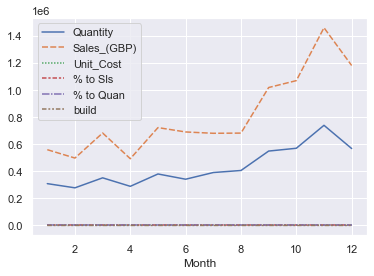

In [548]:
#Starting to create plots for sales
sns.set_theme(style="darkgrid")
sns.lineplot(data=yyz)#,style)
plt.show()

In [549]:
#now I am starting to do calculations for returns now (so everything that has a Return = TRUE flag)
#Largely the same as the gross table, but with the Return Flag to true, not false
#return mask
mask1 = new['ret']
returns = new.loc[mask1, :].copy()

#column calculations
returns['Unit_Price']=returns['Sales_(GBP)']/returns['Quantity']

#total return calculations by month
ttlretdol = returns['Sales_(GBP)'].sum()
ttlretquan = returns['Quantity'].sum()

#just getting a percent to total for returns just like with month--
#this will come in handy to demonstrate the dropoff in sales from 
#Dec>Jan can be partially attributed to Holiday/Gifting returns
returns['% to Ret$'] = returns['Sales_(GBP)'] / ttlretdol
returns['% to RetU'] = returns['Quantity'] / ttlretquan

#total monthly returns DF
ttl_mo_ret = returns.groupby(['Month'])[['Quantity','Sales_(GBP)','% to Ret$','% to RetU']].agg('sum')

#More return calculations
ttl_mo_ret['% to RetU'] = ttl_mo_ret['Quantity'] / ttlretdol
monthly_ttls = (ttlretdol,ttlretquan)
ttl_mo_ret
##ttl_mo_ret = ttl returns only


,Quantity,Sales_(GBP),% to Ret$,% to RetU
Month,,,,
1,-88750,-131364.30,0.146479,0.098962
2,-8706,-25569.24,0.028511,0.009708
3,-33078,-34372.28,0.038327,0.036884
4,-23078,-44601.50,0.049733,0.025733
5,-19034,-47202.51,0.052634,0.021224
6,-52714,-70616.78,0.078742,0.058779
7,-16423,-37921.08,0.042284,0.018313
8,-18817,-54333.75,0.060585,0.020982
9,-25599,-38902.55,0.043379,0.028544


In [550]:
new.columns

Index([  'InvoiceNo',   'StockCode', 'Description',    'Quantity',
         'UnitPrice',  'CustomerID',     'Country',             0,
       'Sales_(GBP)',         'ret',       'Month',         'day',
              'year',        'date',          'Wk',         'woy',
         '454_Month'],
      dtype='object')

In [879]:
#Now I am starting to get into product level analysis, first splitting into products > 10k GBP in rev (there are 217)

prod_tbl = new.groupby(['StockCode','Description'])[['Sales_(GBP)','Quantity']].agg('sum')
above10 = prod_tbl.sort_values(by='Sales_(GBP)',ascending=False).head(217)
topsls = above10['Sales_(GBP)'].sum()
topquan = above10['Quantity'].sum()
prod_tbl

Sales_(GBP)  Quantity
StockCode    Description                                               
10002        INFLATABLE POLITICAL GLOBE                759.89       860
10080        GROOVY CACTUS INFLATABLE                  119.09       303
             check                                       0.00        22
10120        DOGGY RUBBER                               40.53       193
10123C       HEARTS WRAPPING TAPE                        3.25         5
...                                                       ...       ...
gift_0001_20 to push order througha s stock was          0.00        10
gift_0001_30 Dotcomgiftshop Gift Voucher £30.00        175.53         7
gift_0001_40 Dotcomgiftshop Gift Voucher £40.00        100.70         3
gift_0001_50 Dotcomgiftshop Gift Voucher £50.00        167.56         4
m            Manual                                      2.55         1

[4792 rows x 2 columns]

In [552]:
#this is the rest of the products (below 10k GBP in revenue in the yr)
below10 = prod_tbl.sort_values(by='Sales_(GBP)',ascending=False).head(~217)
botsls = below10['Sales_(GBP)'].sum()
botquan = below10['Quantity'].sum()
print(topsls/botsls,topquan/botquan)

0.4722343549120401 0.33655731768860775


In [712]:
#i'm creating a list of Stock Codes and the Unit price associated with them to try and back into a markdown flag
mds = new[['StockCode','UnitPrice']]
mds = mds.apply(tuple,axis=1)
md = pd.DataFrame(set(mds))
md.sort_values(by=[0,1],axis=1,inplace=True, ascending=False)
# md.to_csv('md.csv')
#I exported the Stock Code and unit price, then sorted by StockCode and then Price highest to lowest 
#each product in the csv, then reimported--i used the highest price as the regular price
#for the sake of comapring performance when products are marked down or on promo, I ignored styles that \
#weren't marked down during this period

price_tbl = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/mds.csv')
price_tbl.head()

,StockCode,Unit_Price,Price_Flag,Num_of_Pr,Ever_Marked
0,10002,1.66,Reg_Price,4,Marked
1,10002,1.63,MD,4,Marked
2,10002,0.85,MD,4,Marked
3,10002,0.00,MD,4,Marked
4,10080,0.85,Reg_Price,3,Marked


In [654]:
price_perf = new.copy()
price_perf.head()
pricing_sales = price_perf.merge(price_tbl, how='left', left_on=['StockCode','UnitPrice'], right_on=['StockCode','Unit_Price'])
pricing_sales.head()
# mask1 = pricing_sales['Ever_Marked']=='Marked'
# mask2 = pricing_sales['ret']==False
# pricing_sales.loc[mask2,:]
reg_md = pricing_sales.copy()
reg_md.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy,454_Month,Unit_Price,Price_Flag,Num_of_Pr,Ever_Marked
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC,2.55,MD,10,Marked
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,4,Marked
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC,2.75,MD,11,Marked
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,8,Marked
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,12,Marked


In [878]:
final_pricing = reg_md.groupby(['woy','Wk','Price_Flag'])[['Sales_(GBP)','Quantity']].agg(['sum','count']).copy()
final_pricing['Avg_Qty'] = final_pricing[('Quantity', 'sum')] / final_pricing[('Quantity', 'count')]
final_pricing['Avg_Sls_(GBP)'] = final_pricing[('Sales_(GBP)', 'sum')] / final_pricing[('Sales_(GBP)', 'count')]
final_pricing = final_pricing.reset_index()
final_pricing.columns = final_pricing.columns.get_level_values(0)
final_pricing

,woy,Wk,Price_Flag,Sales_(GBP),Sales_(GBP),Quantity,Quantity,Avg_Qty,Avg_Sls_(GBP)
0,1,JAN Wk 1,MD,71359.78,5804,61434,5804,10.584769,12.294931
1,1,JAN Wk 1,Reg_Price,6650.35,749,3876,749,5.174900,8.878972
2,2,JAN Wk 2,MD,188981.46,8381,85724,8381,10.228374,22.548796
3,2,JAN Wk 2,Reg_Price,10607.69,930,3902,930,4.195699,11.406118
4,3,JAN Wk 3,MD,129317.27,8891,64789,8891,7.287032,14.544738
...,...,...,...,...,...,...,...,...,...
115,49,DEC Wk 2,Reg_Price,51542.44,6332,20816,6332,3.287429,8.139994
116,50,DEC Wk 3,MD,190370.43,9406,104205,9406,11.078567,20.239255
117,50,DEC Wk 3,Reg_Price,26405.35,2669,8011,2669,3.001499,9.893350
118,51,DEC Wk 4,MD,80169.22,3681,39061,3681,10.611519,21.779196


In [656]:
final_pricing.columns

MultiIndex([(          'woy',      ''),
            (           'Wk',      ''),
            (   'Price_Flag',      ''),
            (  'Sales_(GBP)',   'sum'),
            (  'Sales_(GBP)', 'count'),
            (     'Quantity',   'sum'),
            (     'Quantity', 'count'),
            (      'Avg_Qty',      ''),
            ('Avg_Sls_(GBP)',      '')],
           )

In [659]:
all_reg_v_md = final_pricing.groupby(['woy', 'Price_Flag'])[[("Avg_Qty",""),('Avg_Sls_(GBP)','')]].agg(['mean'])
all_reg_v_md

Avg_Qty Avg_Sls_(GBP)
                                       
                     mean          mean
woy Price_Flag                         
1   MD          10.584769     12.294931
    Reg_Price    5.174900      8.878972
2   MD          10.228374     22.548796
    Reg_Price    4.195699     11.406118
3   MD           7.287032     14.544738
...                   ...           ...
49  Reg_Price    3.287429      8.139994
50  MD          11.078567     20.239255
    Reg_Price    3.001499      9.893350
51  MD          10.611519     21.779196
    Reg_Price    2.774238     11.855028

[102 rows x 2 columns]

In [695]:
md_mask = reg_md['Ever_Marked']=='Marked'
before_after_md = reg_md.loc[md_mask, :]
before_after_md
b_a = before_after_md.groupby(['StockCode', 'woy', 'Price_Flag'])[['Sales_(GBP)', 'Quantity']].agg(['sum','count']).copy()
b_a['Week_Count'] = 1
b_a = b_a.reset_index()
b_a.groupby(['Price_Flag'])[[('Sales_(GBP)', 'sum'), ('Quantity','sum'), ('Week_Count', "")]].agg(['sum'])


,Sales_(GBP),Quantity,Week_Count
,sum,sum,
,sum,sum,sum
Price_Flag,,,
MD,9.236491e+06,4926637,91678
Reg_Price,4.898729e+05,240201,18000


In [709]:
b_a['Avg_Wkly_Sls'] = b_a[('Sales_(GBP)','sum')] / b_a[('Week_Count', '')] 
b_a['Avg_Wkly_Quan'] = b_a[('Quantity','sum')] / b_a[('Week_Count', '')] 
b_a
pricing_product_perf = b_a.groupby(['Price_Flag'])[[('Avg_Wkly_Sls',''), ('Avg_Wkly_Quan',"")]].agg(['mean']).copy()
pricing_product_perf['Unit_Price'] = pricing_product_perf[('Avg_Wkly_Sls','')] / pricing_product_perf[('Avg_Wkly_Quan',"")]

In [707]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [710]:
pricing_product_perf

,Avg_Wkly_Sls,Avg_Wkly_Quan,Unit_Price
,,,
,mean,mean,
Price_Flag,,,
MD,100.749268,53.738487,1.874807
Reg_Price,27.215159,13.344500,2.039429


In [789]:
new

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy,454_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,2011-12-09,10.20,False,12,9,2011,2011-12-09,DEC Wk 2,49,DEC
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,2011-12-09,12.60,False,12,9,2011,2011-12-09,DEC Wk 2,49,DEC
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,2011-12-09,16.60,False,12,9,2011,2011-12-09,DEC Wk 2,49,DEC
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,2011-12-09,16.60,False,12,9,2011,2011-12-09,DEC Wk 2,49,DEC


In [630]:
by_prod = new.groupby(['StockCode','Description','Month'])[['Quantity','Sales_(GBP)']].agg(['sum']).copy()

In [813]:
top_week = new.groupby(['StockCode','Description','woy'])[['Quantity','Sales_(GBP)']].agg(['sum']).copy()
top = new.groupby(['StockCode','Description'])[['Quantity','Sales_(GBP)']].agg(['sum']).copy()
rest=[]
top_prod = top.sort_values(('Sales_(GBP)', 'sum'),ascending=False).head(25).reset_index().copy()
rest_prod = top.sort_values(('Sales_(GBP)', 'sum'),ascending=False).iloc[25:,:].reset_index().copy()
top25=[]
for d in top_prod.Description:
    top25.append(d)
for d in rest_prod.Description:
    rest.append(d)

top25
rest
top_prod.columns = top_prod.columns.get_level_values(0)
top_week.reset_index(inplace=True)
top_week.columns = top_week.columns.get_level_values(0)
boolean_ser = top_week.Description.isin(top25)
top_week = top_week.loc[boolean_ser,:]

In [ ]:
#iplot function will display the graph in the notebook, plot will create a 
###separate html file in the notebook folder. It takes a Figure object as the input.
# To create a Figure object, we need to tell plotly what the data is and the layout of the figure.
# To customize the number of bins in the histogram, you need to tell plotly the starting point 
####and the ending point, along with the size of each bin.
# In the layout, we can customize the title of the graph and the gap between two bins.

In [716]:
first_wk = new.copy()
first_week = first_wk.groupby(['StockCode','Description','woy'])[['Quantity', 'Sales_(GBP)']].agg(['sum']).copy()

In [822]:
# first_week = first_week.reset_index()
# first_week = first_week.drop(columns=('index',''))
min_week = first_week.groupby(['StockCode', 'Description'])[[('woy',"")]].agg(['min']).copy()
min_week = min_week.reset_index()
min_week.columns=min_week.columns.get_level_values(0)
min_week

,StockCode,Description,woy
0,10002,INFLATABLE POLITICAL GLOBE,1
1,10080,GROOVY CACTUS INFLATABLE,9
2,10080,check,45
3,10120,DOGGY RUBBER,8
4,10123C,HEARTS WRAPPING TAPE,9
...,...,...,...
4787,gift_0001_20,to push order througha s stock was,24
4788,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1
4789,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,14
4790,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,18


In [844]:
min_week.columns = min_week.columns.get_level_values(0)
min_week = min_week.rename(columns={'woy':'f_wol'})
min_week

,StockCode,Description,f_wol
0,10002,INFLATABLE POLITICAL GLOBE,1
1,10080,GROOVY CACTUS INFLATABLE,9
2,10080,check,45
3,10120,DOGGY RUBBER,8
4,10123C,HEARTS WRAPPING TAPE,9
...,...,...,...
4787,gift_0001_20,to push order througha s stock was,24
4788,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1
4789,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,14
4790,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,18


In [848]:
m1 = min_week['f_wol']>8
m2 = min_week['f_wol']<44
first_week = min_week.loc[m1 & m2,:].copy()
first_week

,StockCode,Description,f_wol
1,10080,GROOVY CACTUS INFLATABLE,9
4,10123C,HEARTS WRAPPING TAPE,9
6,10124G,ARMY CAMO BOOKCOVER TAPE,11
12,15030,FAN BLACK FRAME,12
26,15058A,BLUE POLKADOT GARDEN PARASOL,9
...,...,...,...
4782,PADS,PADS TO MATCH ALL CUSHIONS,15
4785,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,10
4787,gift_0001_20,to push order througha s stock was,24
4789,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,14


In [876]:
plm_track = new.merge(first_week, how='left', left_on='Description', right_on='Description')
prod_to_wol = plm_track['ret']==False
intermed = plm_track.loc[prod_to_wol,:]

plm = intermed.groupby(['Description','woy','f_wol'])[['Sales_(GBP)','Quantity']].agg(['sum']).copy()
plm = plm.reset_index()
plm.columns=plm.columns.get_level_values(0)

plm['prod_wol'] = plm['woy'] - plm['f_wol'] + 1
lifecycle = plm.groupby(['prod_wol'])[['Sales_(GBP)','Quantity']].agg(['mean'])

prod_mask = plm['prod_wol']>0
lifecycle = plm.loc[prod_mask,:]
lifecycle.groupby(['prod_wol'])[['Sales_(GBP)','Quantity']].agg(['mean'])

,Sales_(GBP),Quantity
,mean,mean
prod_wol,,
1.0,129.309048,76.531328
2.0,165.060529,84.176471
3.0,145.530257,86.089124
4.0,143.866780,78.010786
5.0,149.729832,87.961832
6.0,136.859906,73.076682
7.0,132.424853,70.874419
8.0,146.451158,76.916107
